In [1]:
import torch
from torch import nn
from torch.utils.tensorboard import SummaryWriter
from pytorch_tabnet.tab_model import TabNetRegressor
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# TabNet: Attentive Interpretable Tabular Learning

In [2]:
seed = 42
np.random.seed(seed)

df = pd.read_csv('dataset.csv')
display(df.head())
print(f'Number of samples: {df.shape[0]}')

,rating_mean,007,007 (series),18th century,1920s,1930s,1950s,1960s,1970s,1980s,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,3.893708,0.02875,0.02375,0.06250,0.07575,0.14075,0.14675,0.06350,0.20375,0.2020,...,0,0,0,0,0,0,0,0,0,0
1,3.251527,0.04125,0.04050,0.06275,0.08275,0.09100,0.06125,0.06925,0.09600,0.0765,...,0,0,0,0,0,0,0,0,0,0
2,3.142028,0.04675,0.05550,0.02925,0.08700,0.04750,0.04775,0.04600,0.14275,0.0285,...,0,0,0,0,0,1,0,0,0,0
3,2.853547,0.03425,0.03800,0.04050,0.03100,0.06500,0.03575,0.02900,0.08650,0.0320,...,0,0,0,0,0,1,0,0,0,0
4,3.058434,0.04300,0.05325,0.03800,0.04100,0.05400,0.06725,0.02775,0.07650,0.0215,...,0,0,0,0,0,0,0,0,0,0


Number of samples: 13798


In [3]:
# PyTorch Device
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print("Using {} device".format(device))

Using cpu device


### Data Preprocessing

In [4]:
X = df.drop('rating_mean', axis=1)
y = df['rating_mean']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=seed)

X_train = X_train.to_numpy()
X_val = X_val.to_numpy()
X_test = X_test.to_numpy()

y_train = y_train.to_numpy()
y_val = y_val.to_numpy()
y_test = y_test.to_numpy()

In [5]:
y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)
print('Number of training samples:', X_train.shape[0])
print('Number of validation samples:', X_val.shape[0])
print('Number of test samples:', X_test.shape[0])

Number of training samples: 9934
Number of validation samples: 1104
Number of test samples: 2760


# Tab Net Architecture

In [6]:
# Hyperparameters
num_epochs = 200
batch_size = 128
v_batch_size = 256

# Number of consecutive epochs without improvement before performing early stopping.
patience = 10
# Coefficient for feature reusage in the masks. A value close to 1 will make mask selection least correlated between layers. Values range from 1.0 to 2.0.
gamma = 1.3
# Dimension of the prediction layer
n_d = 16
# Dimension of the attentional layer
n_a = 16
# Number of steps in the architecture (usually between 3 and 10)
n_steps = 5
# Number of shared GLU layer in each GLU block (Default 2)
n_shared = 2
# Number of independent GLU layer in each GLU block (Default 2)
n_independent = 2

tabnet_params = dict(
    n_d=n_d,
    n_a=n_a,
    n_steps=n_steps,
    gamma=gamma,
    n_independent=n_independent,
    n_shared=n_shared,
    optimizer_fn=torch.optim.Adam,
    seed=seed,
)

model = TabNetRegressor(**tabnet_params)

/home/diego/PycharmProjects/pythonProject/venv/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [7]:
# Training

model.fit(
    X_train=X_train,
    y_train=y_train,
    eval_set=[(X_val, y_val)],
    eval_name=["val"],
    eval_metric=['rmsle', 'mae', 'rmse', 'mse'],
    max_epochs=num_epochs,
    patience=patience,
    batch_size=batch_size,
    virtual_batch_size=v_batch_size,
    num_workers=0,
    drop_last=False,
    loss_fn=torch.nn.functional.mse_loss,
)

epoch 0  | loss: 1.21682 | val_rmsle: 0.0201  | val_mae: 0.5097  | val_rmse: 0.58932 | val_mse: 0.3473  |  0:00:04s
epoch 1  | loss: 0.21298 | val_rmsle: 0.00999 | val_mae: 0.32713 | val_rmse: 0.40295 | val_mse: 0.16237 |  0:00:09s
epoch 2  | loss: 0.14635 | val_rmsle: 0.00973 | val_mae: 0.30034 | val_rmse: 0.38988 | val_mse: 0.152   |  0:00:13s
epoch 3  | loss: 0.10642 | val_rmsle: 0.00574 | val_mae: 0.22913 | val_rmse: 0.30051 | val_mse: 0.09031 |  0:00:18s
epoch 4  | loss: 0.08046 | val_rmsle: 0.00559 | val_mae: 0.26031 | val_rmse: 0.31227 | val_mse: 0.09751 |  0:00:22s
epoch 5  | loss: 0.07219 | val_rmsle: 0.00454 | val_mae: 0.20564 | val_rmse: 0.2677  | val_mse: 0.07166 |  0:00:27s
epoch 6  | loss: 0.06501 | val_rmsle: 0.00287 | val_mae: 0.17236 | val_rmse: 0.21788 | val_mse: 0.04747 |  0:00:31s
epoch 7  | loss: 0.04826 | val_rmsle: 0.00214 | val_mae: 0.147   | val_rmse: 0.18797 | val_mse: 0.03533 |  0:00:36s
epoch 8  | loss: 0.04006 | val_rmsle: 0.00238 | val_mae: 0.16246 | val_r

/home/diego/PycharmProjects/pythonProject/venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [8]:
# Evaluation
saving_path = 'tabnet_model'
saved_filepath = model.save_model(saving_path)

loaded_model = TabNetRegressor()
loaded_model.load_model(saved_filepath)

Successfully saved model at tabnet_model.zip


/home/diego/PycharmProjects/pythonProject/venv/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [9]:
# Predictions
y_pred = loaded_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse}')
print(f'R2: {r2}')

MSE: 0.006256630993984402
R2: 0.9722617300592946


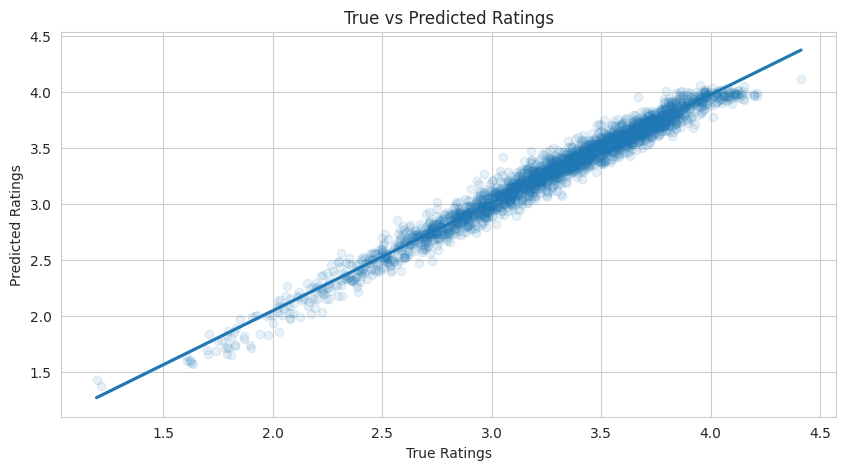

In [10]:
# Plotting
plt.figure(figsize=(10, 5))
sns.regplot(x=y_test, y=y_pred, scatter_kws={'alpha':0.1})
plt.xlabel('True Ratings')
plt.ylabel('Predicted Ratings')
plt.title('True vs Predicted Ratings')
plt.show()

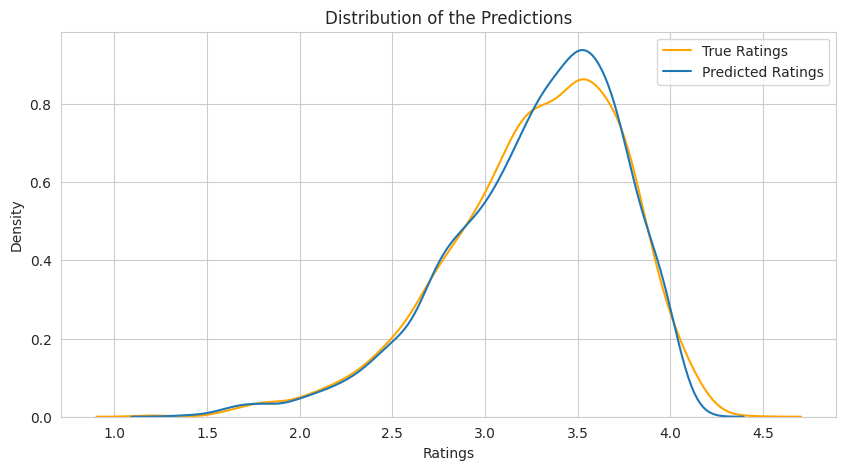

In [11]:
# Distribution of the predictions
plt.figure(figsize=(10, 5))
sns.kdeplot(y_test, color='orange')
sns.kdeplot(y_pred, color='b')
plt.xlabel('Ratings')
plt.ylabel('Density')
plt.title('Distribution of the Predictions')
plt.legend(['True Ratings', 'Predicted Ratings'])
plt.show()